In [1]:
## Below code required to access Google drive resources
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Keras and TF imports
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [0]:
# Scikit-learn and Numpy imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

In [0]:
# set the location of the training and test images (change as required)
location_of_train_data = "drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_train"
location_of_test_data = "drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_test"
model_folder_name = "drive/My Drive/Extending board games online/models/16_12"

In [0]:
class_names = ["white_bishop", "white_king", "white_knight", "white_pawn", "white_queen", "white_rook", "black_bishop", "black_king", "black_knight", "black_pawn", "black_queen", "black_rook", "empty"]
class_names_reverse_mappings = {"white_bishop": 0, "white_king": 1, "white_knight":2, "white_pawn":3, "white_queen":4, "white_rook":5, "black_bishop": 6, "black_king": 7, "black_knight": 8, "black_pawn": 9, "black_queen": 10, "black_rook": 11, "empty":12}
class_names_folder_mappings = {"white_bishop": ["wb"], "white_king": ["wk"], "white_knight":["wn"], "white_pawn":["wp"], "white_queen":["wq"], "white_rook":["wr"], "black_bishop": ["bb"], "black_king": ["bk"], "black_knight":["bn"], "black_pawn":["bp"], "black_queen":["bq"], "black_rook":["br"], "empty":["empty"]}

In [0]:
from keras.applications.inception_v3 import preprocess_input

def get_required_data_with_labels_for_model(base_location, num_samples = None, dimensions=(299, 299)):
  X, y = [], []
  for class_name in class_names_folder_mappings:
    for folder_name in class_names_folder_mappings[class_name]:
      complete_path = os.path.join(base_location, folder_name)
      print("Reading the files from the location {0}".format(complete_path))
      current_samples = 0
      for image_file_name in os.listdir(complete_path):
        
        # check if the current file is an image file with jpg extension
        if image_file_name.endswith(".jpg"):
          current_samples += 1
          img_path = os.path.join(complete_path, image_file_name)
          
          # basic pre-processing of the images
          img = image.load_img(img_path, target_size=dimensions)
          x = image.img_to_array(img)
          x = preprocess_input(x)
          
          X.append(x)
          class_name_id = class_names_reverse_mappings[class_name]
          y.append(class_name_id)
        
          if ((num_samples is not None) and (current_samples == num_samples)):
            break
  
  return X, y    
  

In [7]:
X_train, y_train = get_required_data_with_labels_for_model(location_of_train_data, 100)
print(len(X_train))
print(len(y_train))
print(X_train[0].shape)
print(y_train[0])

Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_train/wb
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_train/wk
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_train/wn
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_train/wp
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_train/wq
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_train/wr
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_train/bb
Reading the files from the location drive/My Drive/Exte

In [8]:
X_test, y_test = get_required_data_with_labels_for_model(location_of_test_data, 10)
print(len(X_test))
print(len(y_test))
print(X_test[0].shape)
print(y_test[0])

Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_test/wb
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_test/wk
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_test/wn
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_test/wp
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_test/wq
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_test/wr
Reading the files from the location drive/My Drive/Extending board games online/chess_pieces_data/Chess ID Public Data/output_test/bb
Reading the files from the location drive/My Drive/Extending b

In [9]:
## update the base inception v3 model

num_output_classes = len(class_names)
print(num_output_classes)

# create the base pre-trained model
inception_v3_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = inception_v3_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)

predictions = Dense(num_output_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=inception_v3_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in inception_v3_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

13
87916544/87910968 [==============================] - 7s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_________________________________________

In [0]:
if not os.path.exists(model_folder_name):
    os.makedirs(model_folder_name)

In [0]:
# checkpoint
filepath=os.path.join(model_folder_name, "chess_pieces_inceptionv3_p1.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=50, min_delta= 0.0001)
callbacks_list = [checkpoint, early_stopping]

In [0]:
epochs = 100
batch_size = 100

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)
history = model.fit(X_train,
          y_train,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=callbacks_list,
          batch_size=batch_size)

Train on 1300 samples, validate on 102 samples
Epoch 1/50
1300/1300 [==============================] - 24s 18ms/step - loss: 6.0120 - acc: 0.2862 - val_loss: 5.3366 - val_acc: 0.2941

Epoch 00001: val_acc improved from -inf to 0.29412, saving model to drive/My Drive/Extending board games online/models/16_12/chess_pieces_inceptionv3_p1.hdf5
Epoch 2/50
1300/1300 [==============================] - 13s 10ms/step - loss: 3.7121 - acc: 0.5108 - val_loss: 4.2209 - val_acc: 0.4020

Epoch 00002: val_acc improved from 0.29412 to 0.40196, saving model to drive/My Drive/Extending board games online/models/16_12/chess_pieces_inceptionv3_p1.hdf5
Epoch 3/50
1300/1300 [==============================] - 13s 10ms/step - loss: 2.9227 - acc: 0.6246 - val_loss: 3.2781 - val_acc: 0.4706

Epoch 00003: val_acc improved from 0.40196 to 0.47059, saving model to drive/My Drive/Extending board games online/models/16_12/chess_pieces_inceptionv3_p1.hdf5
Epoch 4/50
1300/1300 [==============================] - 13s 10

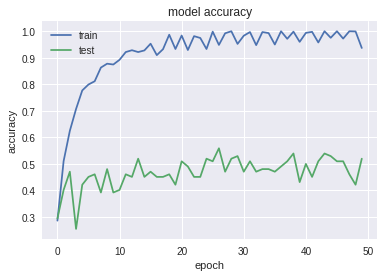

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
## Fine tune some inception layers
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [0]:
# checkpoint
filepath=os.path.join(model_folder_name, "chess_pieces_inceptionv3_p2.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_acc', patience=25, min_delta= 0.01)
callbacks_list = [checkpoint, early_stopping]

In [0]:
epochs = 100
batch_size = 100

In [18]:
history_2 = model.fit(X_train,
          y_train,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=callbacks_list,
          batch_size=batch_size)

Train on 1300 samples, validate on 102 samples
Epoch 1/20
1300/1300 [==============================] - 24s 19ms/step - loss: 0.0094 - acc: 0.9977 - val_loss: 1.9977 - val_acc: 0.6275

Epoch 00001: val_acc improved from -inf to 0.62745, saving model to drive/My Drive/Extending board games online/models/16_12/chess_pieces_inceptionv3_p2.hdf5
Epoch 2/20
1300/1300 [==============================] - 17s 13ms/step - loss: 0.0070 - acc: 0.9992 - val_loss: 1.9960 - val_acc: 0.6275

Epoch 00002: val_acc did not improve from 0.62745
Epoch 3/20
1300/1300 [==============================] - 17s 13ms/step - loss: 0.0055 - acc: 0.9992 - val_loss: 2.0018 - val_acc: 0.6275

Epoch 00003: val_acc did not improve from 0.62745
Epoch 4/20
1300/1300 [==============================] - 17s 13ms/step - loss: 0.0064 - acc: 0.9992 - val_loss: 1.9967 - val_acc: 0.6176

Epoch 00004: val_acc did not improve from 0.62745
Epoch 5/20
1300/1300 [==============================] - 17s 13ms/step - loss: 0.0074 - acc: 1.000

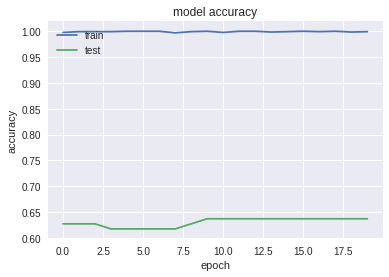

In [19]:
# summarize history for accuracy
plt.plot(history_2.history['acc'])
plt.plot(history_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
## Helper method to print a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Score: [1.9920576974457385, 0.637254902252964]
Normalized confusion matrix
[[0.57142857 0.         0.         0.28571429 0.14285714 0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.4        0.         0.         0.6        0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.9        0.1        0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.22222222 0.         0.         0.11111111 0.11111111 0.55555556
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.375      0.         0.625      0.         0.        ]
 [0.         0

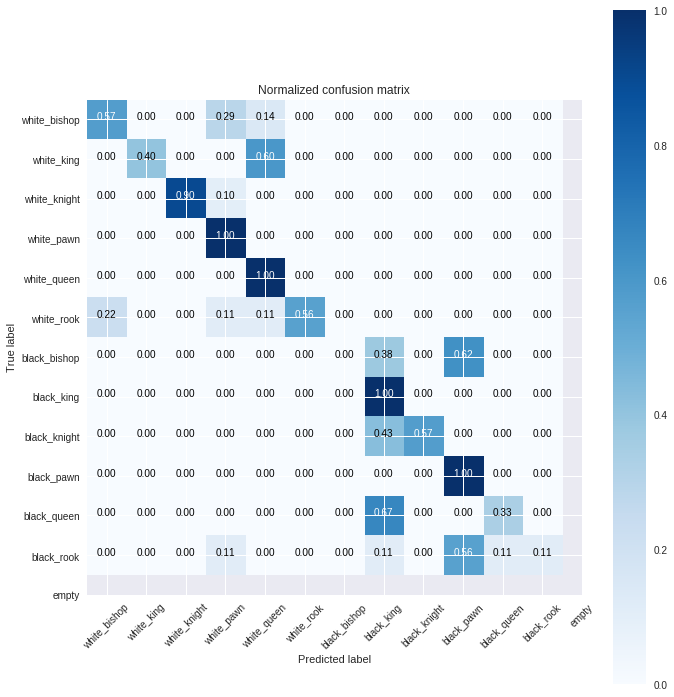

In [21]:
model.load_weights(os.path.join(model_folder_name, "chess_pieces_inceptionv3_p2.hdf5"))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=['accuracy'],
)
score = model.evaluate(X_test, y_test, verbose=0)

print("Score: " + str(score))

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

test_predictions = model.predict(X_test, batch_size=batch_size)
y_test_pred = [np.argmax(x) for x in test_predictions]
cnf_matrix = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')